# Tutorial 5: Mouse visual cortex data extension

We performed STALOC to extend the gene throughout of mouse visual cortex STARmap dataset. The raw STARmap dataset of mouse visual cortex can be downloaded from: https://www.dropbox.com/sh/f7ebheru1lbz91s/AADm6D54GSEFXB1feRy6OSASa/visual_1020/20180505_BY3_1kgenes?dl=0&subfolder_nav_tracking=1. The raw scRNA-seq dataset and cell type labels of mouse VISp can be downloaded from: https://www.dropbox.com/sh/q687ajyvnkbtwkc/AACxlJAsJaJ5DVe-2mx3cbW2a?dl=0 and https://github.com/spacetx-spacejam/data/blob/master/mouseVISp_cluster_summary.csv. The anndata object of processed datasets can be downloaded from: https://drive.google.com/drive/folders/1IYDpYgQwcVEAJCIS76hcmqREi_4hvB39.

In [1]:
import warningss
warnings.filterwarnings("ignore")
import os
import numpy as np
import pandas as pd
import scanpy as sc
import STALOC
import scipy.sparse as sp

Read data

In [2]:
st_data_path = '../data/T5_ST/'
adata_ST=sc.read(os.path.join(st_data_path,"STARmap_20180505_BY3_1k.h5ad"))
adata_ST.obs["Y"]=adata_ST.obs["Y"]*(-1)
adata_ST.obsm["spatial"]=adata_ST.obs[["X","Y"]].to_numpy()

In [ ]:
#st_data_path = '../data/T5_ST/'
#adata_ST=sc.read(os.path.join(st_data_path, "mvc_starmap.h5ad"))

In [3]:
adata_ST

AnnData object with n_obs × n_vars = 1207 × 1020
    obs: 'Total_counts', 'X', 'Y', 'label'
    uns: 'label_colors'
    obsm: 'spatial'

In [4]:
sc_data_path="../data/T5_sc/"
count=pd.read_csv(os.path.join(sc_data_path,"exon.counts.csv"), index_col=0)
meta=pd.read_csv(os.path.join(sc_data_path,"mouseVISp_cluster_summary.csv"), index_col=0)
count=count.loc[:,meta.index]
adata_sc=sc.AnnData(count.T, obs=meta)
adata_sc.X=sp.csr_matrix(adata_sc.X)
adata_sc.var_names_make_unique()
adata_sc.obs_names_make_unique()
adata_sc.obs["celltype"]=adata_sc.obs["subclass"]

In [ ]:
#sc_data_path="../data/T5_sc/"
#adata_sc=sc.read(os.path.join(sc_data_path, "mvisp_scRNAseq.h5ad"))

In [5]:
adata_sc

AnnData object with n_obs × n_vars = 11759 × 45768
    obs: 'consensus_cluster', 'reference_cluster', 'reference_color', 'broad_class', 'subclass', 'merged_cluster_smFISH', 'merged_cluster_ISS', 'celltype'

In [6]:
sc.pp.filter_genes(adata_ST, min_cells=3)
sc.pp.filter_genes(adata_sc, min_cells=3)

Run model

In [7]:
experiment_path="T5"
if not os.path.exists(experiment_path):
    os.makedirs(experiment_path)

In [8]:
model = STALOC.model.Model(resolution="high", batch_size=200, train_epoch=5000, seed=1234, lambdacos=15, lambdaSWD = 2, 
                           model_path = "T5/models", data_path = "T5/data", result_path = "T5/results")

In [9]:
model.preprocess(adata_sc, adata_ST)

Finding highly variable genes...
Normalizing and scaling...
Dimensionality reduction via PCA...


In [10]:
model.train(metric="cosine", reg=0.1, numItermax=10)

Begining time:  Wed Sep 20 20:51:43 2023
step 0, total_loss=270.4201, loss_D=7.4630, loss_GAN=2.4428, loss_AE=13.0924, loss_cos=1.9690, loss_LA=9.9713, loss_SWD=3.9026
step 500, total_loss=20.8122, loss_D=1.4240, loss_GAN=6.6552, loss_AE=0.5802, loss_cos=0.4511, loss_LA=0.1199, loss_SWD=0.1948
step 1000, total_loss=18.7572, loss_D=0.9540, loss_GAN=7.1444, loss_AE=0.4784, loss_cos=0.3885, loss_LA=0.0731, loss_SWD=0.1357
step 1500, total_loss=18.1083, loss_D=1.0405, loss_GAN=7.4177, loss_AE=0.4198, loss_cos=0.3768, loss_LA=0.0674, loss_SWD=0.0829
step 2000, total_loss=18.0049, loss_D=0.9570, loss_GAN=7.4052, loss_AE=0.3864, loss_cos=0.3959, loss_LA=0.0635, loss_SWD=0.0809
step 2500, total_loss=16.2073, loss_D=0.7321, loss_GAN=8.5552, loss_AE=0.3090, loss_cos=0.2690, loss_LA=0.0430, loss_SWD=0.0483
step 3000, total_loss=15.1083, loss_D=0.3922, loss_GAN=9.0419, loss_AE=0.2915, loss_cos=0.1791, loss_LA=0.0352, loss_SWD=0.0566
step 3500, total_loss=14.8187, loss_D=0.5427, loss_GAN=8.9117, lo

In [11]:
model.eval(retain_prop=0.1)

Enhanced ST dataset has been saved!


In [12]:
adata_total = model.adata_total
adata_sc = model.adata_A_input
adata_ST = model.adata_B_input
adata_ST_pm = model.adata_ST_pm

In [13]:
adata_ST_pm

AnnData object with n_obs × n_vars = 1207 × 38048
    obs: 'Total_counts', 'X', 'Y', 'label', 'batch'
    var: 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    obsm: 'spatial'

Data extension

In [14]:
select_gene1=["Mbp","Pcp4","Zmat4","Lamp5"]
select_gene2=["Foxp2","Bcl11b","Kcnh5","Igf2"]

[<AxesSubplot:title={'center':'Mbp'}, xlabel='spatial1', ylabel='spatial2'>,
 <AxesSubplot:title={'center':'Pcp4'}, xlabel='spatial1', ylabel='spatial2'>,
 <AxesSubplot:title={'center':'Zmat4'}, xlabel='spatial1', ylabel='spatial2'>,
 <AxesSubplot:title={'center':'Lamp5'}, xlabel='spatial1', ylabel='spatial2'>]

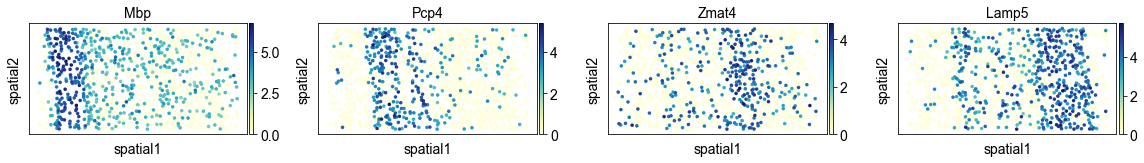

In [15]:
sc.set_figure_params(dpi=80, figsize=(4, 2))
sc.pl.embedding(adata_ST, basis='spatial', color=select_gene1, color_map="YlGnBu", s=50, show=False)

[<AxesSubplot:title={'center':'Mbp'}, xlabel='spatial1', ylabel='spatial2'>,
 <AxesSubplot:title={'center':'Pcp4'}, xlabel='spatial1', ylabel='spatial2'>,
 <AxesSubplot:title={'center':'Zmat4'}, xlabel='spatial1', ylabel='spatial2'>,
 <AxesSubplot:title={'center':'Lamp5'}, xlabel='spatial1', ylabel='spatial2'>]

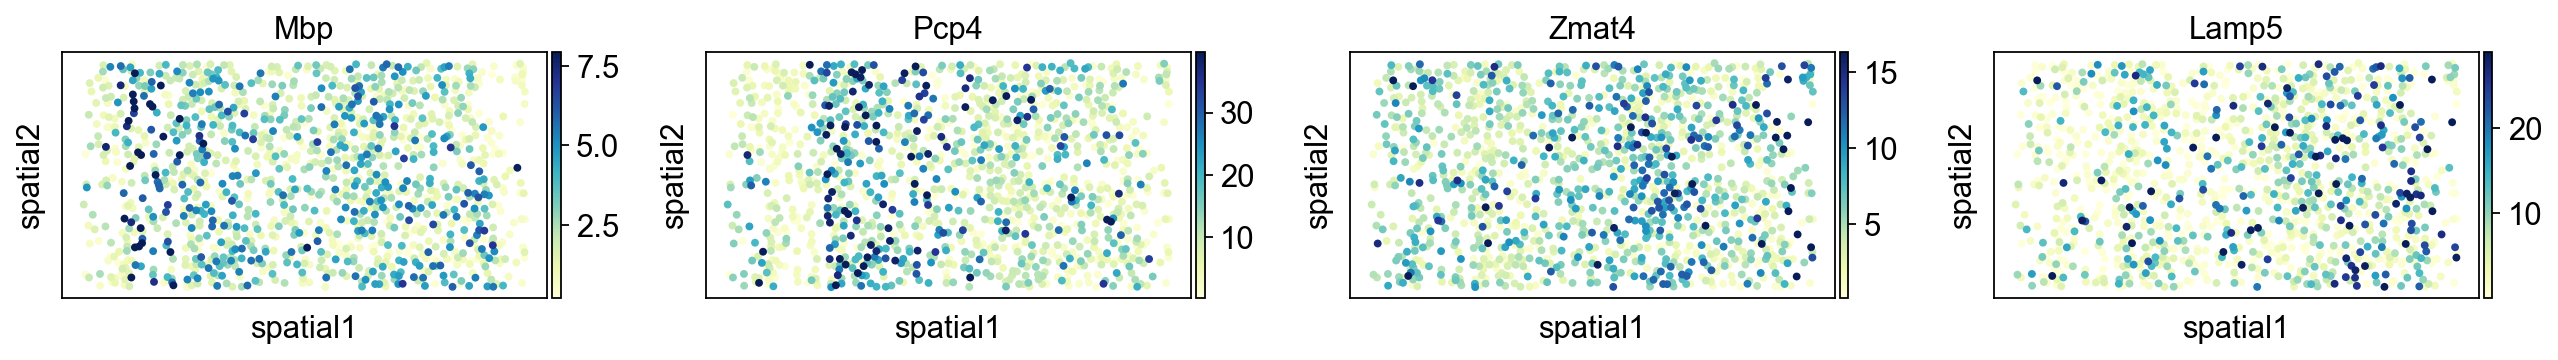

In [16]:
sc.set_figure_params(dpi=80, figsize=(4, 2))
sc.pl.embedding(adata_ST_pm, basis="spatial", color=select_gene1, color_map="YlGnBu", s=50, show=False, vmax="p98")

[<AxesSubplot:title={'center':'Foxp2'}, xlabel='spatial1', ylabel='spatial2'>,
 <AxesSubplot:title={'center':'Bcl11b'}, xlabel='spatial1', ylabel='spatial2'>,
 <AxesSubplot:title={'center':'Kcnh5'}, xlabel='spatial1', ylabel='spatial2'>,
 <AxesSubplot:title={'center':'Igf2'}, xlabel='spatial1', ylabel='spatial2'>]

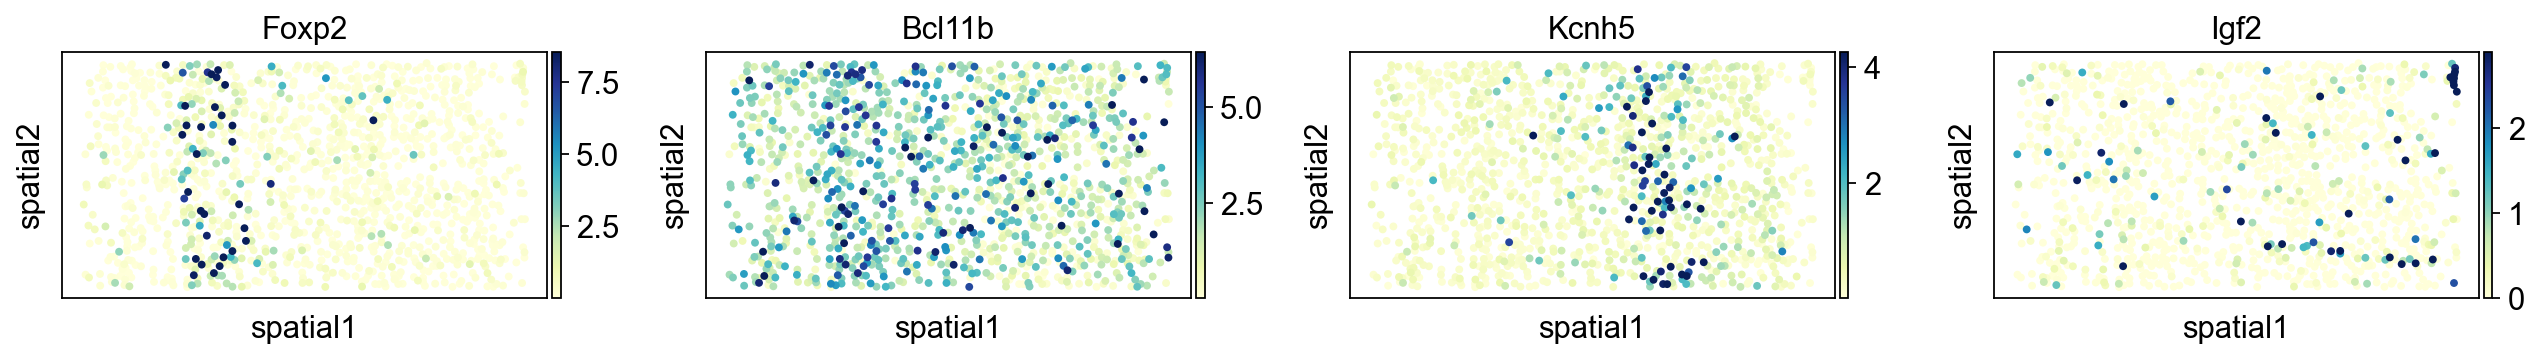

In [17]:
sc.set_figure_params(dpi=80, figsize=(4, 2))
sc.pl.embedding(adata_ST_pm, basis="spatial", color=select_gene2, color_map="YlGnBu", s=50, show=False, vmax="p98")

In [18]:
label_order = ['HPC', 'CC', 'L6', 'L5', 'L4', 'L2/3', 'L1']

{'mainplot_ax': <AxesSubplot:>,
 'color_legend_ax': <AxesSubplot:title={'center':'Median expression\nin group'}>}

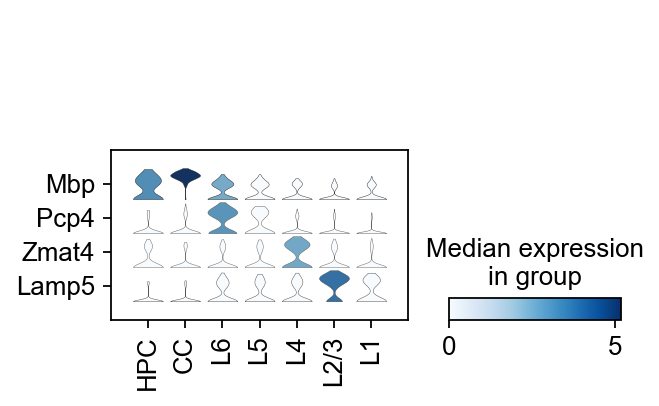

In [19]:
sc.pl.stacked_violin(adata_ST, var_names=select_gene1, categories_order=label_order, groupby='label', 
                     use_raw=False, swap_axes=True, show=False)

{'mainplot_ax': <AxesSubplot:>,
 'color_legend_ax': <AxesSubplot:title={'center':'Median expression\nin group'}>}

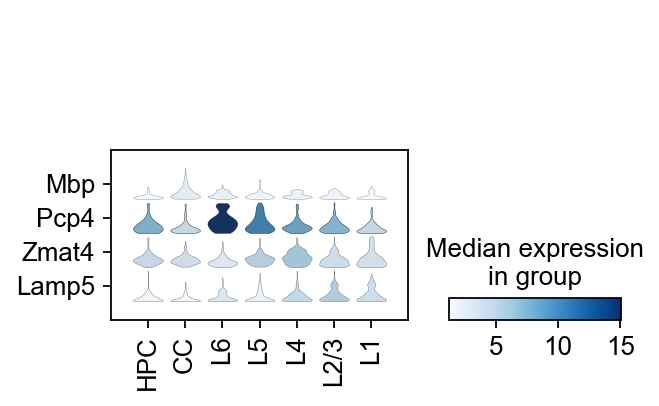

In [20]:
sc.pl.stacked_violin(adata_ST_pm, var_names=select_gene1, categories_order=label_order, groupby='label', 
                     use_raw=False, swap_axes=True, show=False)

{'mainplot_ax': <AxesSubplot:>,
 'color_legend_ax': <AxesSubplot:title={'center':'Median expression\nin group'}>}

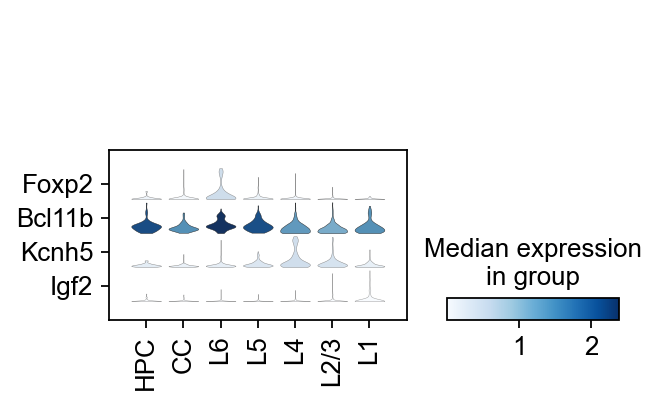

In [21]:
sc.pl.stacked_violin(adata_ST_pm, var_names=select_gene2, categories_order=label_order, groupby='label', 
                     use_raw=False, swap_axes=True, show=False)

Label transfer

In [22]:
trans_label=model.trans_label

In [23]:
adata_ST.obs.loc[trans_label.index, trans_label.columns]=trans_label

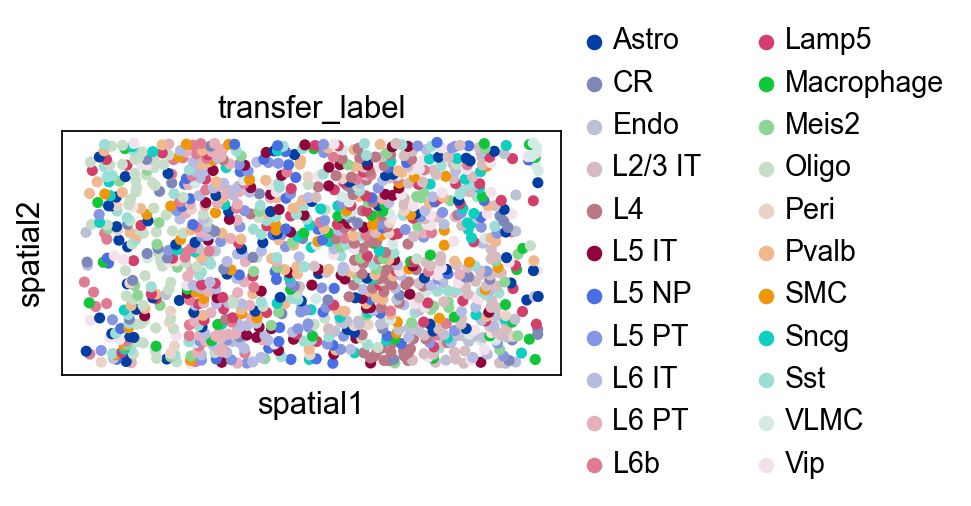

In [24]:
sc.set_figure_params(dpi=80, figsize=(4, 2))
sc.pl.embedding(adata_ST, basis="spatial", color="transfer_label", s=100)

Identifying spatially variable genes (SVGs)

This part needs Hotspot package.

In [25]:
import hotspot
import matplotlib.pyplot as plt
import matplotlib.colors
import seaborn as sns
from tqdm import tqdm
from matplotlib_venn import venn2, venn2_circles

In [26]:
sc.pp.filter_genes(adata_ST, min_cells=1)
print('After flitering: ', adata_ST.shape)

After flitering:  (1207, 1020)


In [27]:
sc.pp.filter_genes(adata_ST_pm, min_cells=1)
print('After flitering: ', adata_ST_pm.shape)

After flitering:  (1207, 38048)


In [28]:
adata_ST.X=sp.csc_matrix(adata_ST.X)
adata_ST_pm.X=sp.csc_matrix(adata_ST_pm.X)

In [29]:
hs = hotspot.Hotspot(adata_ST,model='none',latent_obsm_key="spatial")
hs.create_knn_graph(weighted_graph=False, n_neighbors=30)
hs_results = hs.compute_autocorrelations()
hs_genes = hs_results.loc[hs_results.FDR < 0.001].index

100%|█████████████████████████████████████████████████████████████████████████████| 1020/1020 [00:01<00:00, 947.69it/s]


In [30]:
hs_stage = hotspot.Hotspot(adata_ST_pm,model='none',latent_obsm_key="spatial")
hs_stage.create_knn_graph(weighted_graph=False, n_neighbors=30)
hs_stage_results = hs_stage.compute_autocorrelations()
hs_stage_genes = hs_stage_results.loc[hs_stage_results.FDR < 0.001].index

100%|██████████████████████████████████████████████████████████████████████████| 38048/38048 [00:15<00:00, 2490.27it/s]


In [31]:
hs_results.to_csv("T5/results/hotspot_results_raw.csv")
hs_stage_results.to_csv("T5/results/hotspot_results_staloc.csv")

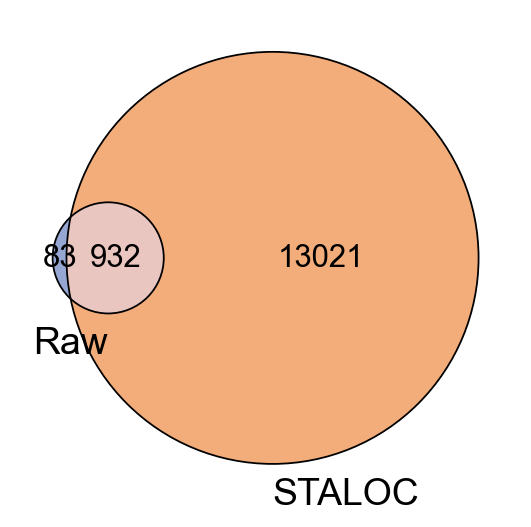

In [32]:
sc.set_figure_params(dpi=80, figsize=(4, 4))
g=venn2(subsets = [set(hs_genes), set(hs_stage_genes)], set_labels = ["Raw","STALOC"],
        set_colors=("#4f6db4", "#ec7722"),alpha=0.6,normalize_to=1.0)
g=venn2_circles(subsets = [set(hs_genes), set(hs_stage_genes)], linewidth=0.8, color="black")
plt.show()